In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/AI_Project/Final'

## Importing all Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats 
import math
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator


## Filtering Data based on products and stores

In [ ]:
data = pd.read_csv(path+'/Coffee_Stores_Data.csv')
stores_data = data[data['StoreID'].isin([18,117,332])]
products = ['Honey Raisin Bran Muffin','Jalapeno Cheese Bagel', 'Lemon Loaf', 'Mixed Berries & Granola Yogurt Parfait', 'Mixed Fruit Snack Pot', 'Muffin - Blueberry Streusel', 'Muffin - Double Chocolate', 'New York Cheesecake', 'Plain Bagel', 'Pressed Juicery Spicy Greens w Ginger', 'Protein Box', 'Smoked Salmon Sandwich', 'Tasty Tuna Salad Sandwich', 'Vive Juice Shot']
dataset = stores_data[stores_data['Description'].isin(products)]
store_18 = dataset[dataset['StoreID']==18]
store_117 = dataset[dataset['StoreID']==117]
store_332 = dataset[dataset['StoreID']==332]

# Section 1

## Generate Graphs for inventory patterns, stock out patterns and missed sales

In [ ]:
def generate_graphs(individual_store):
  ax = sns.barplot(y="Description", x="ReceivedQuantity", data=individual_store, palette="Set2")
  sns.catplot(y='Description', x='ReceivedQuantity', data=individual_store, linewidth=2.5, palette="Set2", orient="h",  kind="box",height=6, aspect=3).set(title='ReceivedQuantity per Product')
  ax = sns.barplot(y="Description", x="StockedOut", data=individual_store, palette="Set2")
  sns.catplot(y='Description', x='StockedOut', data=individual_store, linewidth=2.5, palette="Set2", orient="h",  kind="box",height=6, aspect=1).set(title='Stocked Out per Product')
  ax = sns.barplot(y="Description", x="MissedSales", data=individual_store, palette="Set2")
  sns.catplot(y='Description', x='MissedSales', data=individual_store, linewidth=2.5, palette="Set2", orient="h",  kind="box",height=6, aspect=1).set(title='Missed Sales per Product')

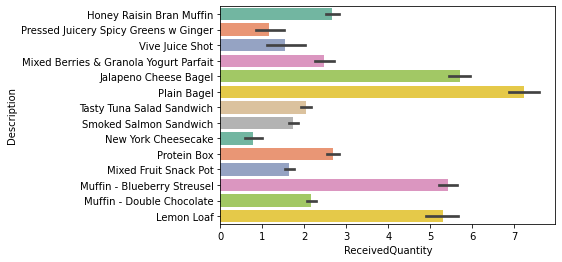

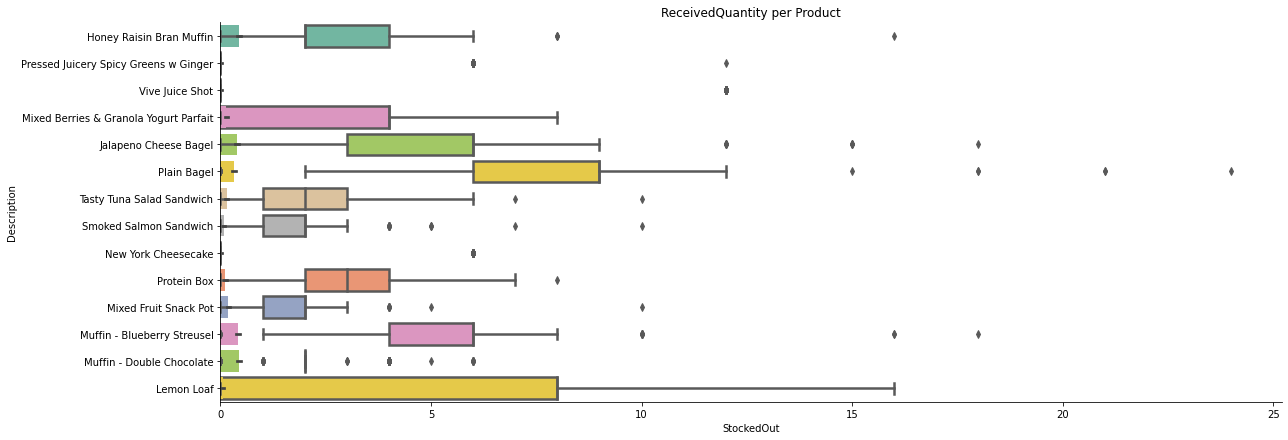

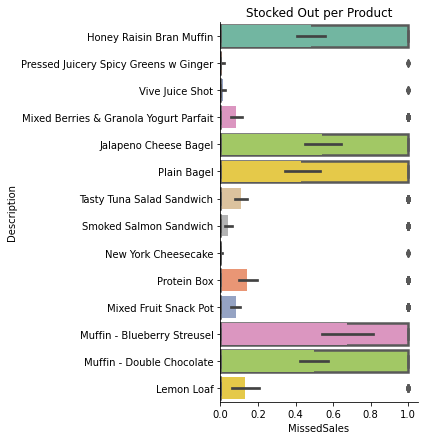

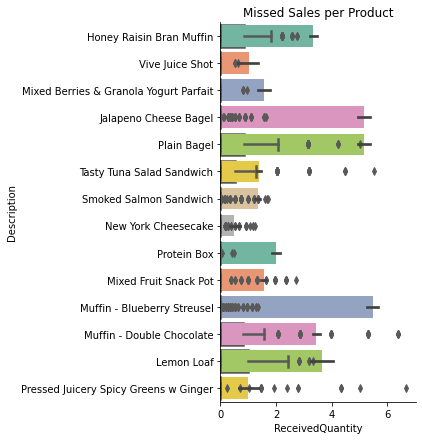

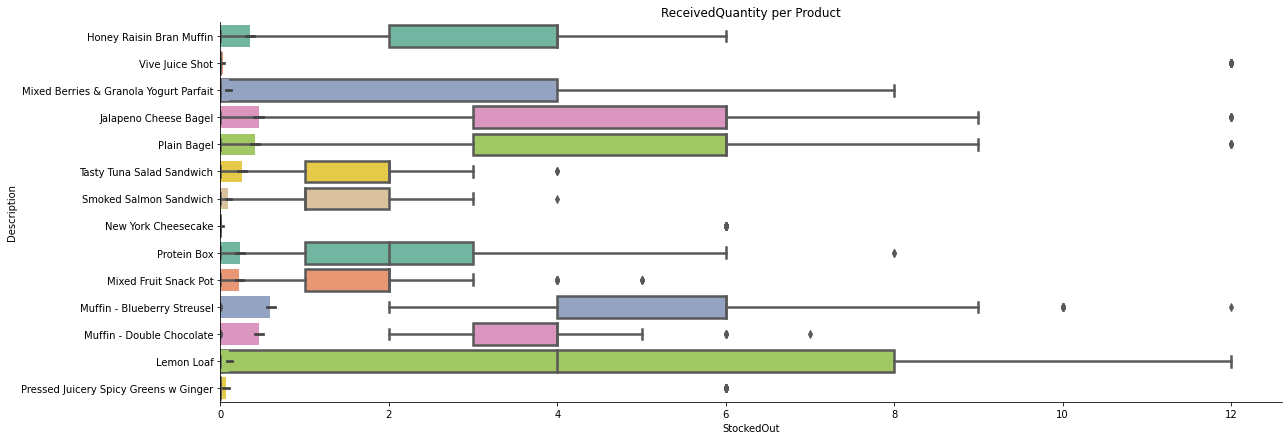

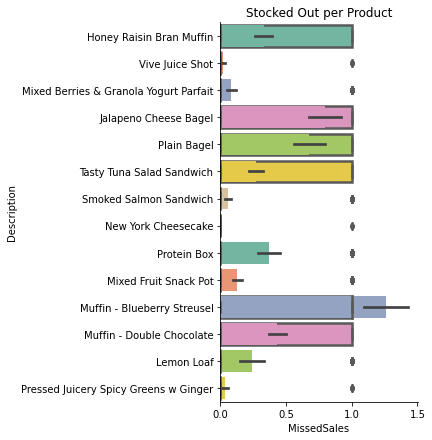

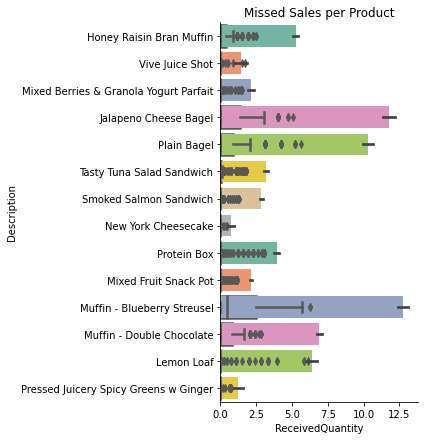

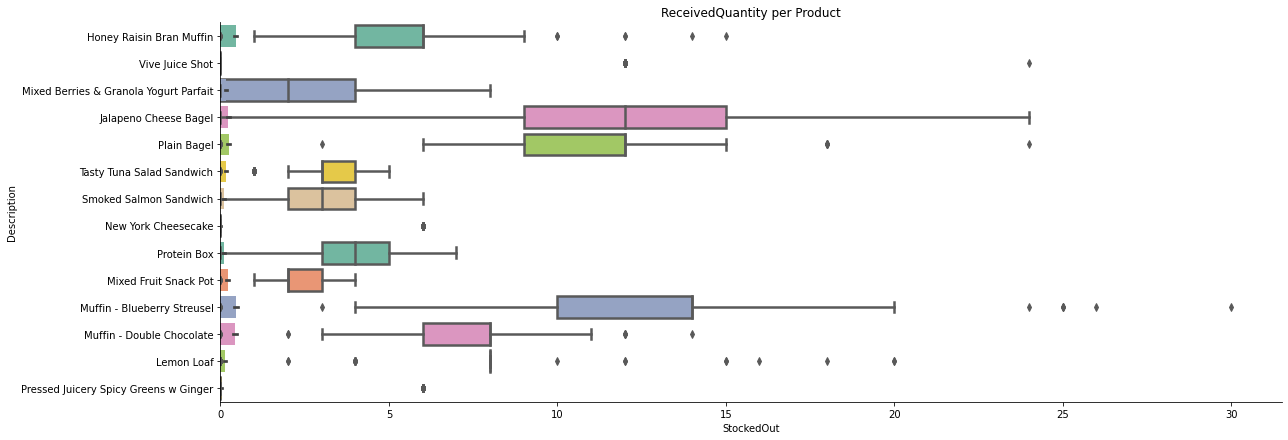

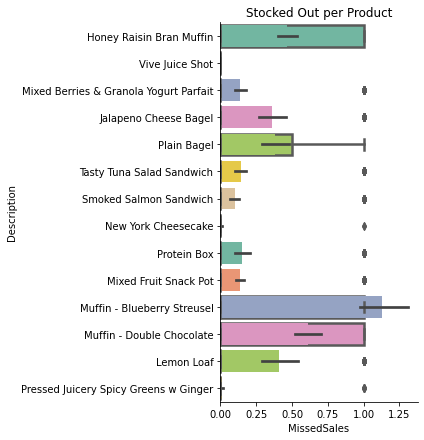

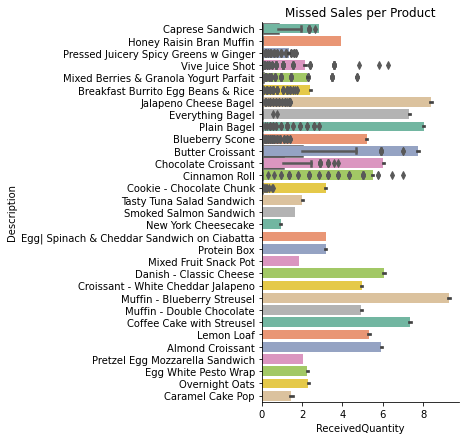

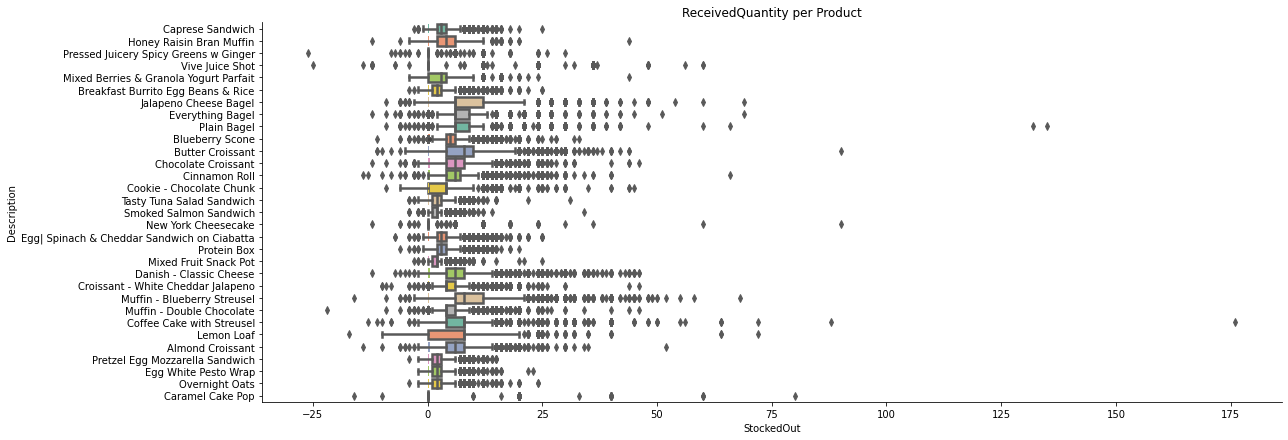

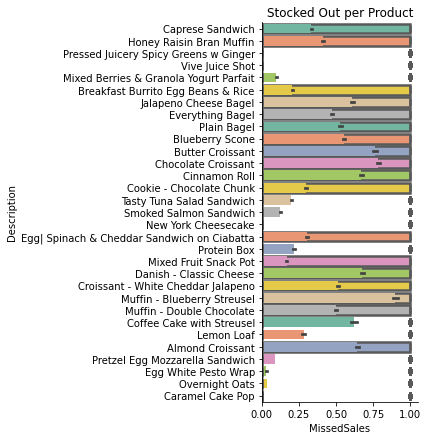

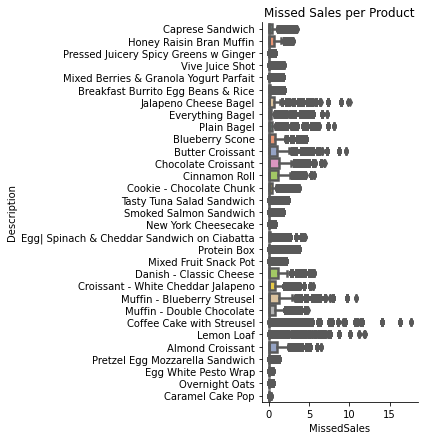

In [ ]:
generate_graphs(store_18)    # For Store 18
generate_graphs(store_117)   # For Store 117
generate_graphs(store_332)   # For Store 332
generate_graphs(data)        # For ALL Stores


## Graphs of best seller and worst seller products of top 25% and bottom 25% 

In [ ]:
def best_and_worst(individual_store):
  list_of_products = individual_store['Description'].unique()
  total_sales = []
  for product in list_of_products:
    sales = individual_store.loc[individual_store['Description'] == product, 'SoldQuantity'].sum()
    total_sales.append(sales)
  #Bar plot for annual sales per product
  plt.figure(figsize=(20,6))
  sns.barplot(list_of_products, total_sales, palette="Set2", dodge = False).set(title='Annual number of sales per product')
  plt.xticks(rotation=45)
  plt.show()
  # get top 25% best seller
  sales_dict = dict(zip(list_of_products,total_sales))
  # sort by total sales value to get top 25% and bottom 25%
  sorted_sales = sorted(sales_dict.items(), key=lambda x: x[1])
  num_top = math.floor(len(list_of_products) * 0.25)
  # create a dataframe with sorted annual sales
  sorted_sales_annual = pd.DataFrame.from_records(sorted_sales, columns=['product','sales'])
  # get top 25% products (from the bottom of the dataframe)
  df_top_products = sorted_sales_annual.loc[len(sorted_sales_annual)-num_top:]
  # bar plot for annual sales per product
  plt.figure(figsize=(10,6))
  sns.barplot(x='product', y='sales', data=df_top_products, palette="Set2", dodge = False).set(title='Annual number of sales of best 25% seller products')
  plt.show()

  # Top 25% seller products list
  top_products = df_top_products['product'].values
  top_sellers_df = individual_store.loc[individual_store['Description'].isin(top_products)]
  # # Merge sales records to daily records for each product.
  partial_top_sellers_df = top_sellers_df[['BusinessDate', 'Description', 'SoldQuantity']]
  df_top0 = partial_top_sellers_df[partial_top_sellers_df['Description']==top_products[0]]
  df_top1 = partial_top_sellers_df[partial_top_sellers_df['Description']==top_products[1]]
  df_top2 = partial_top_sellers_df[partial_top_sellers_df['Description']==top_products[2]]
  # bar plot for annual sales per product
  plt.figure(figsize=(20,6))
  sns.lineplot(data=df_top0, x='BusinessDate', y='SoldQuantity',palette="Set2")
  sns.lineplot(data=df_top1, x='BusinessDate', y='SoldQuantity', palette="Set2")
  sns.lineplot(data=df_top2, x='BusinessDate', y='SoldQuantity',palette="Set2")
  plt.legend(labels=[top_products[0],top_products[1],top_products[2]])
  plt.title("Top 25% best sellers daily sold quantity over one year period")
  plt.show()
  # Get the bottom 25% sellers, plot the sum of sold quantity over the one year period and daily sold quantities for top sellers.
  df_bottom_products = sorted_sales_annual.loc[0:num_top-1]
  print(df_bottom_products)
  sns.barplot(x='product', y='sales', data=df_bottom_products, palette="Set2", dodge = False).set(title='Annual number of sales of worst 25% seller products')
  bottom_products = df_bottom_products['product'].values
  bottom_sellers_df = individual_store.loc[individual_store['Description'].isin(bottom_products)]
  partial_bottom_sellers_df = bottom_sellers_df[['BusinessDate', 'Description', 'SoldQuantity']]
  df_bottom0 = partial_bottom_sellers_df[partial_bottom_sellers_df['Description']==bottom_products[0]]
  df_bottom1 = partial_bottom_sellers_df[partial_bottom_sellers_df['Description']==bottom_products[1]]
  df_bottom2 = partial_bottom_sellers_df[partial_bottom_sellers_df['Description']==bottom_products[2]] 
  plt.figure(figsize=(20,6))
  sns.lineplot(data=df_bottom0, x='BusinessDate', y='SoldQuantity',palette="Set2")
  sns.lineplot(data=df_bottom1, x='BusinessDate', y='SoldQuantity', palette="Set2")
  sns.lineplot(data=df_bottom2, x='BusinessDate', y='SoldQuantity',palette="Set2")
  plt.legend(labels=[bottom_products[0],bottom_products[1],bottom_products[2]])
  plt.title("Bottom 25% sellers daily sold quantity over one year period (6/29/2019- 6/29/2020")
  plt.show() 


In [ ]:
best_and_worst(store_18)    # 18th Store
best_and_worst(store_117)   # 117th Store
best_and_worst(store_332)   # 332 Store
best_and_worst(data)        # FOR ALL STORES

Output hidden; open in https://colab.research.google.com to view.

## Graphs of best and worst products based on their inventory management

In [ ]:
def inventory_graphs(individual_store):
  #Annual Total Inventory (ReceivedQuantity) by product
  list_of_products = individual_store['Description'].unique()
  total_inventory = []
  for product in list_of_products:
    inventory = individual_store.loc[individual_store['Description'] == product, 'ReceivedQuantity'].sum()
    total_inventory.append(inventory)
  # Bar plot for annual inventory (Received Quantity) for all products
  plt.figure(figsize=(20,6))
  sns.barplot(list_of_products, total_inventory, palette="Set2", dodge = False).set(title='Annual number of inventory per product')
  plt.xticks(rotation=45)
  plt.show()
  # get top 25% product with most inventory
  inventory_dict = dict(zip(list_of_products,total_inventory))
  # sore by total inventory value to get top 25% and bottom 25%
  sorted_inventory = sorted(inventory_dict.items(), key=lambda x: x[1])
  num_top = math.floor(len(list_of_products) * 0.25)
  # create a dataframe with sorted annual inventory per product
  inv_df = pd.DataFrame.from_records(sorted_inventory, columns=['product','inventory'])
  # get top 25% products (from the bottom of the dataframe)
  df_top_products = inv_df.loc[len(inv_df)-num_top:]
  # bar plot for annual sales per product
  plt.figure(figsize=(10,6))
  sns.barplot(x='product', y='inventory', data=df_top_products, palette="Set2", dodge = False).set(title='Top 25% products with the most Inventory (annual)')
  plt.show()
  # Top 25% seller products list
  top_products = df_top_products['product'].values
  top_inventory_df = individual_store.loc[individual_store['Description'].isin(top_products)]
  partial_top_inventory_df = top_inventory_df[['BusinessDate', 'Description', 'ReceivedQuantity']]
  df_top0 = partial_top_inventory_df[partial_top_inventory_df['Description']==top_products[0]]
  df_top1 = partial_top_inventory_df[partial_top_inventory_df['Description']==top_products[1]]
  df_top2 = partial_top_inventory_df[partial_top_inventory_df['Description']==top_products[2]]
  #Top 25% most inventory products and their daily inventory quantity over one year period
  plt.figure(figsize=(20,6))
  sns.lineplot(data=df_top0, x='BusinessDate', y='ReceivedQuantity',palette="Set2")
  sns.lineplot(data=df_top1, x='BusinessDate', y='ReceivedQuantity', palette="Set2")
  sns.lineplot(data=df_top2, x='BusinessDate', y='ReceivedQuantity',palette="Set2")
  plt.legend(labels=[top_products[0],top_products[1],top_products[2]])
  plt.show()
  # get bottom 25% products
  df_bottom_products = inv_df.loc[0:num_top-1]
  # bar plot for annual sales per product
  plt.figure(figsize=(10,6))
  sns.barplot(x='product', y='inventory', data=df_bottom_products, palette="Set2", dodge = False).set(title='Annual inventory for the bottom 25% inventory products')
  plt.show()
  # Bottom 25% inventory products list
  bottom_products = df_bottom_products['product'].values
  bottom_inventory_df = individual_store.loc[individual_store['Description'].isin(bottom_products)]
  partial_bottom_inventory_df = bottom_inventory_df[['BusinessDate', 'Description', 'ReceivedQuantity']]
  df_bottom0 = partial_bottom_inventory_df[partial_bottom_inventory_df['Description']==bottom_products[0]]
  df_bottom1 = partial_bottom_inventory_df[partial_bottom_inventory_df['Description']==bottom_products[1]]
  df_bottom2 = partial_bottom_inventory_df[partial_bottom_inventory_df['Description']==bottom_products[2]]
  #Bottom 25% inventory products and their daily received quantity over one year period (6/29/2019- 6/29/2020)
  plt.figure(figsize=(20,6))
  sns.lineplot(data=df_bottom0, x='BusinessDate', y='ReceivedQuantity',palette="Set2")
  sns.lineplot(data=df_bottom1, x='BusinessDate', y='ReceivedQuantity', palette="Set2")
  sns.lineplot(data=df_bottom2, x='BusinessDate', y='ReceivedQuantity',palette="Set2")
  plt.legend(labels=[bottom_products[0],bottom_products[1],bottom_products[2]])
  plt.show()



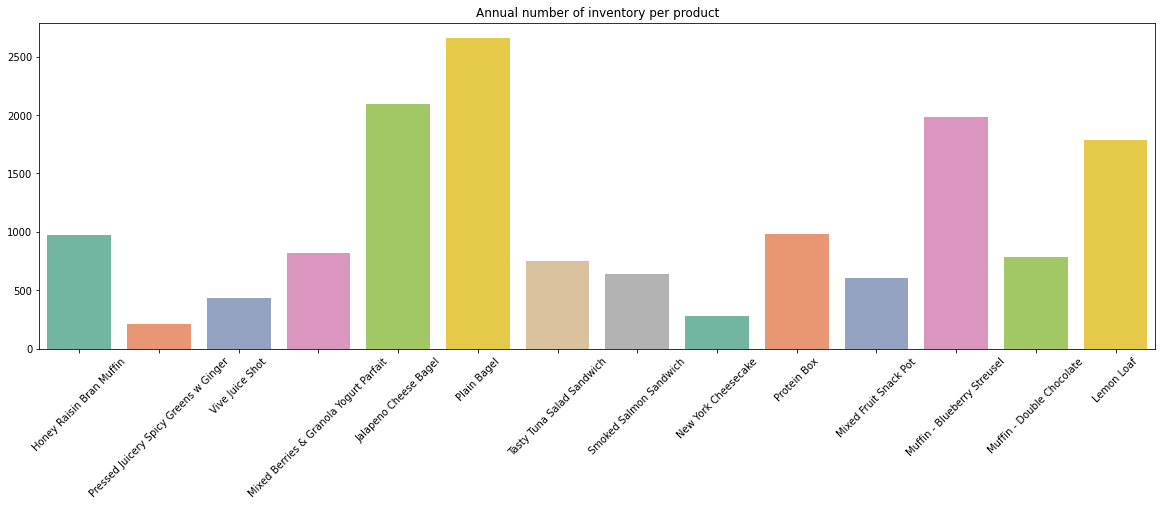

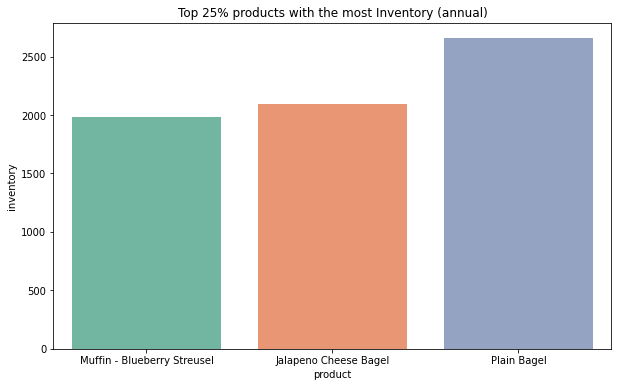

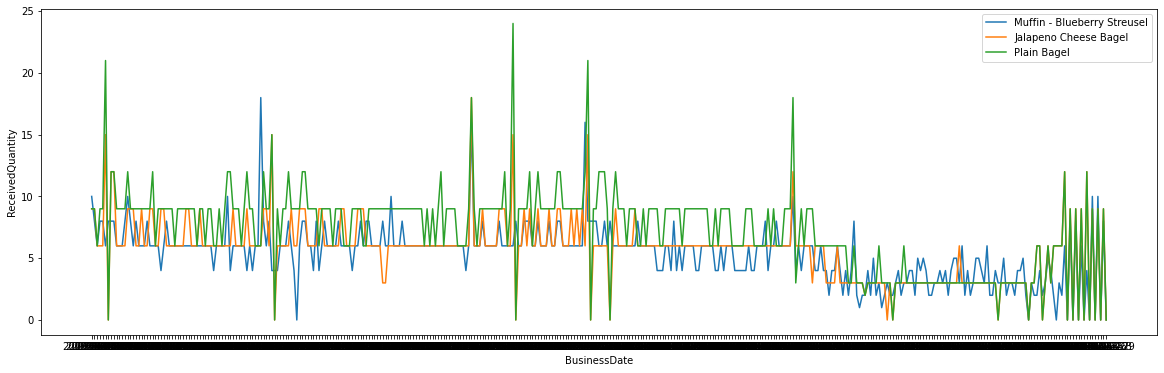

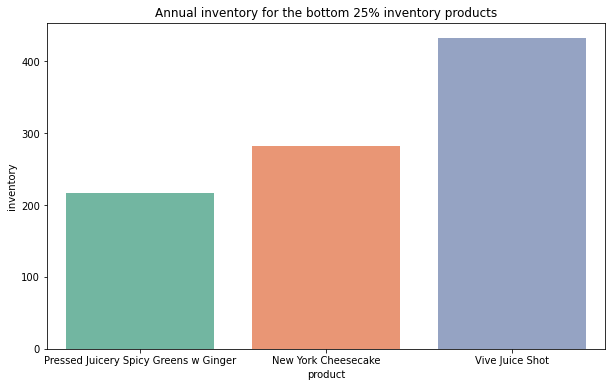

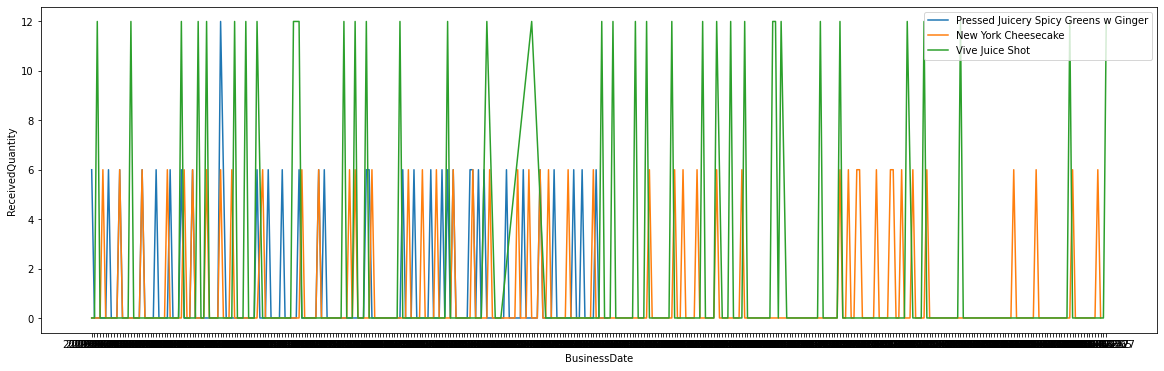

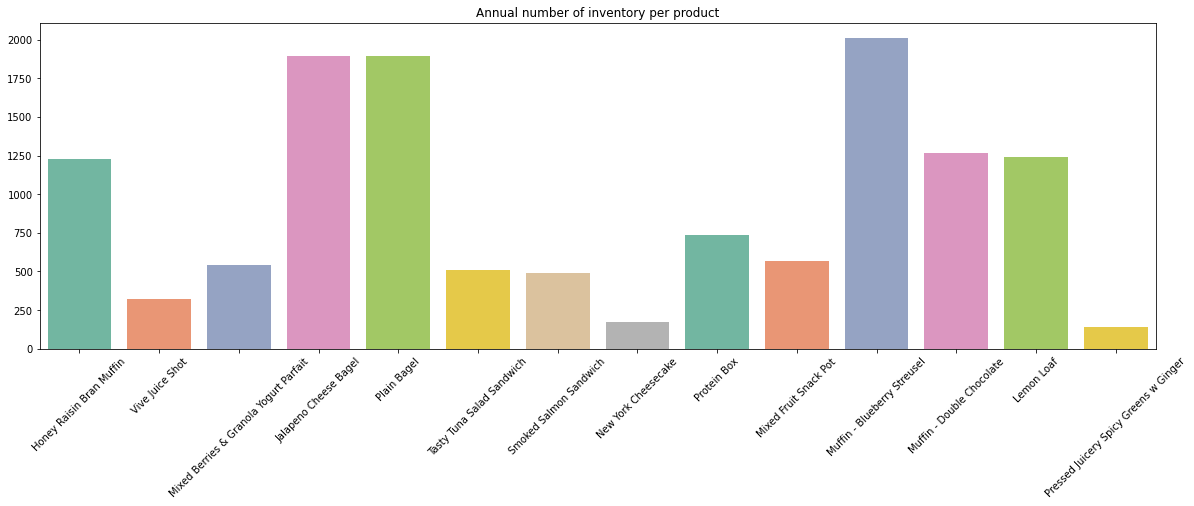

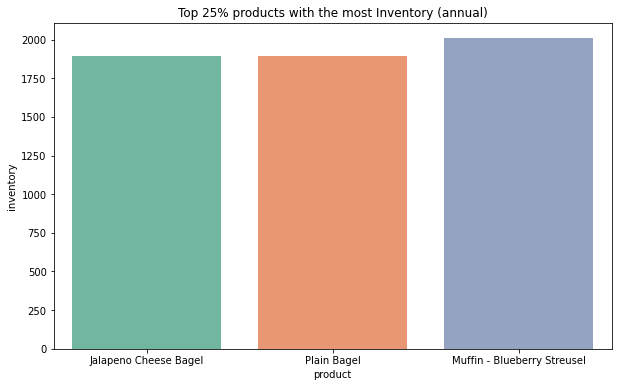

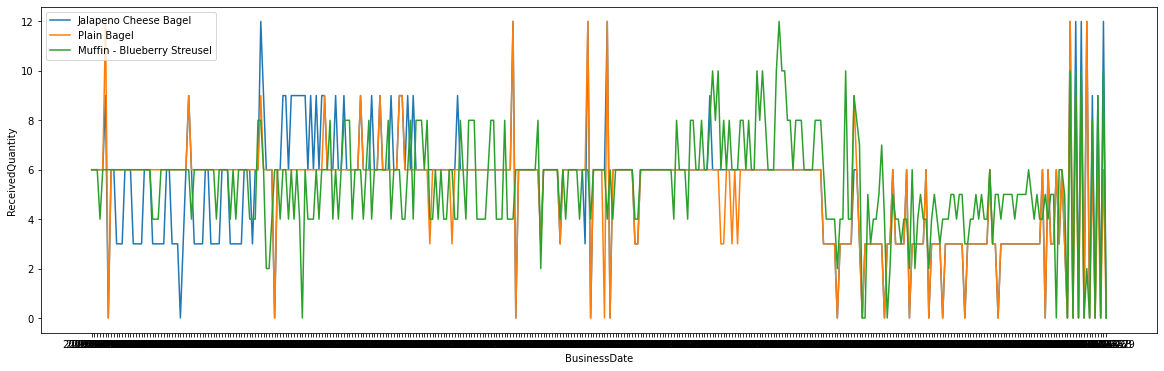

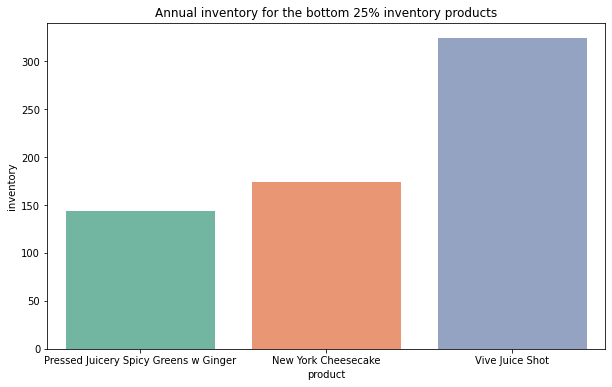

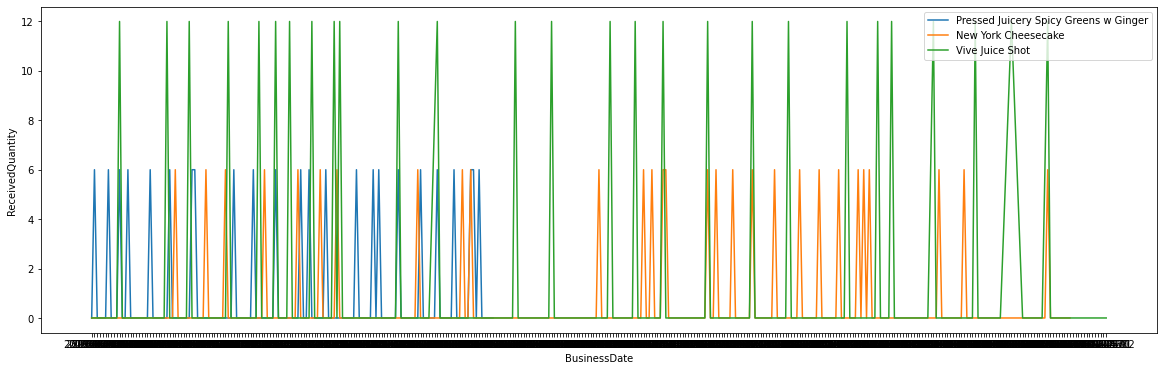

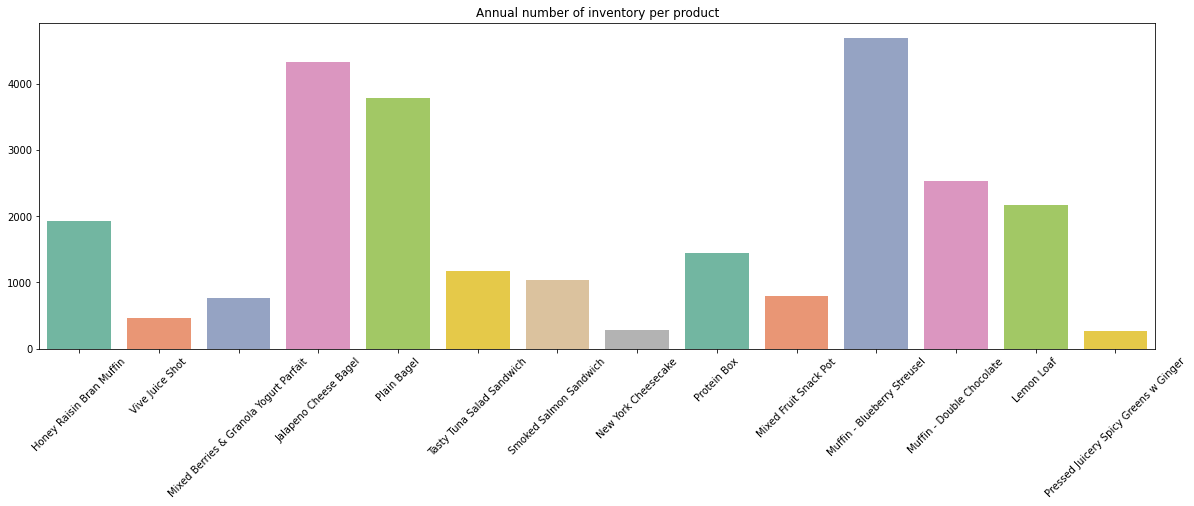

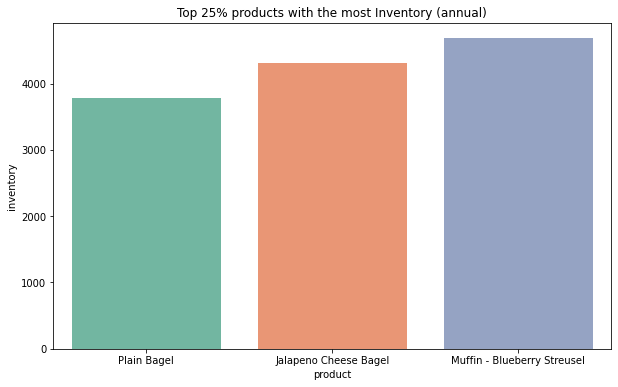

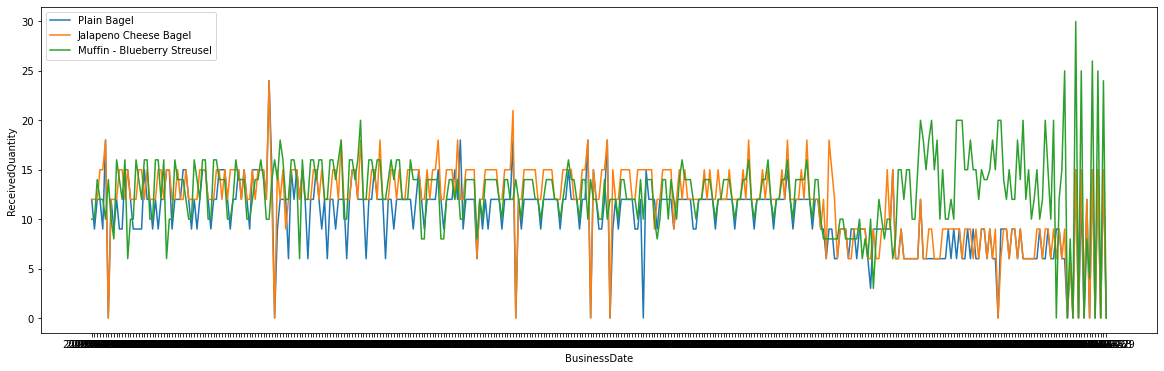

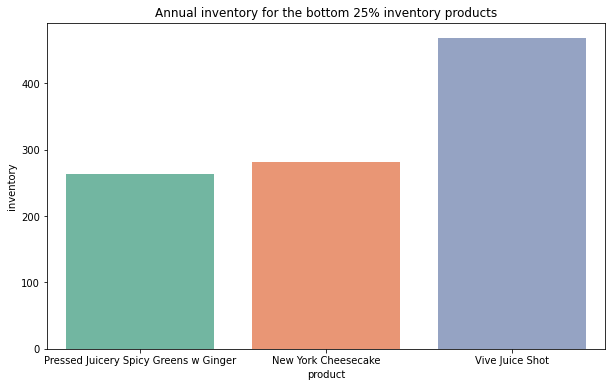

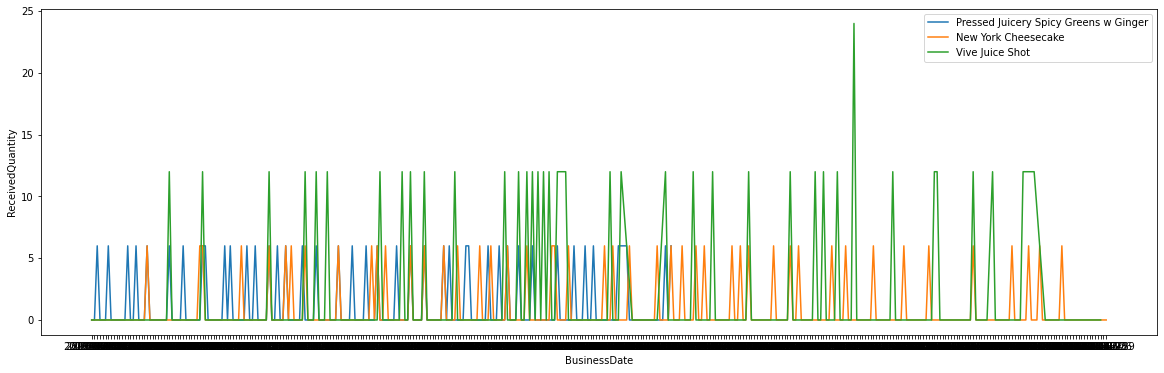

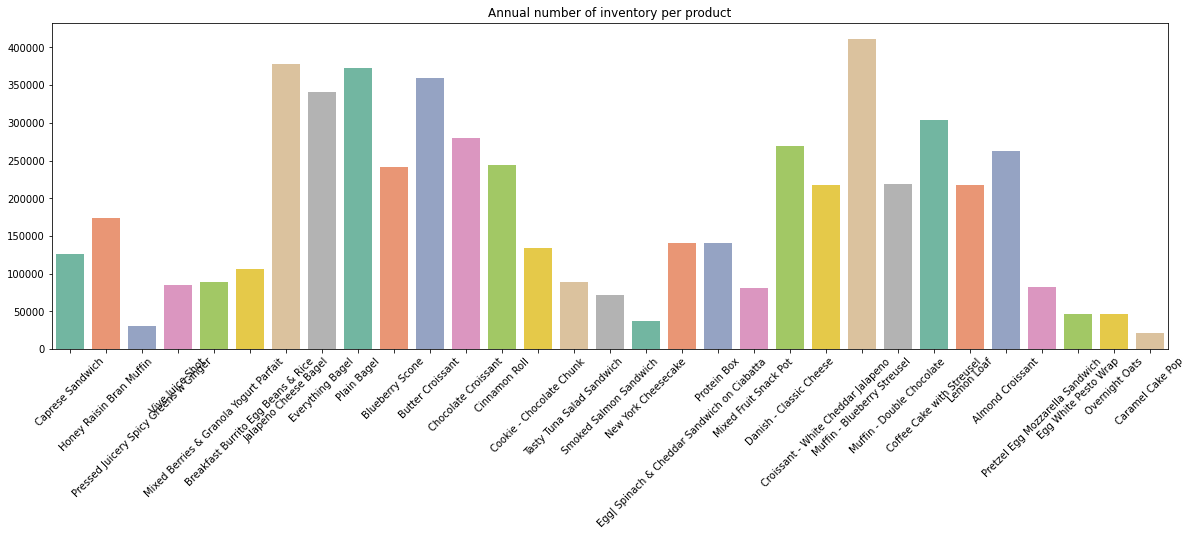

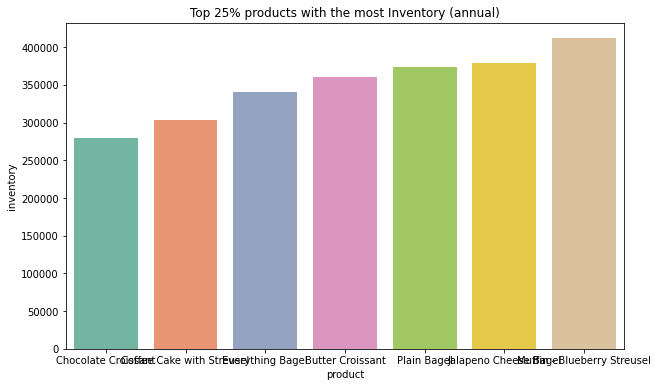

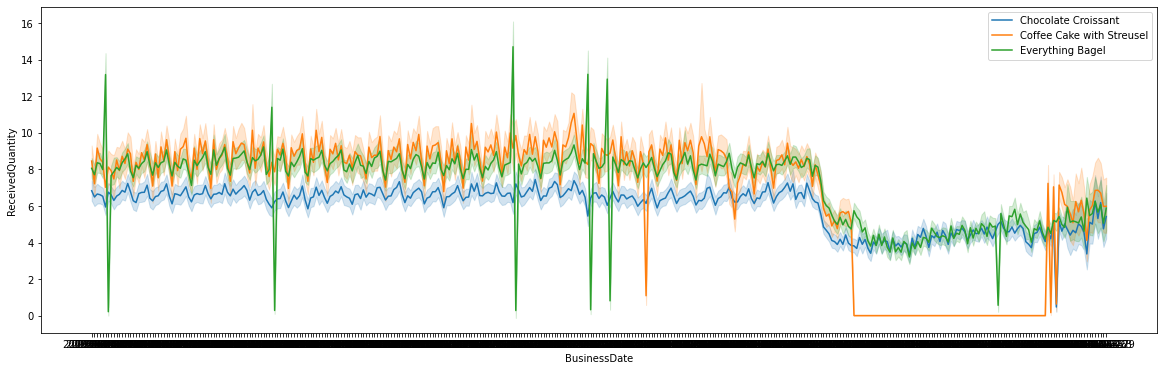

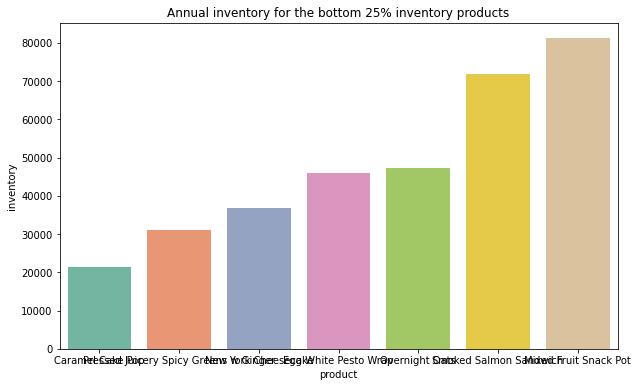

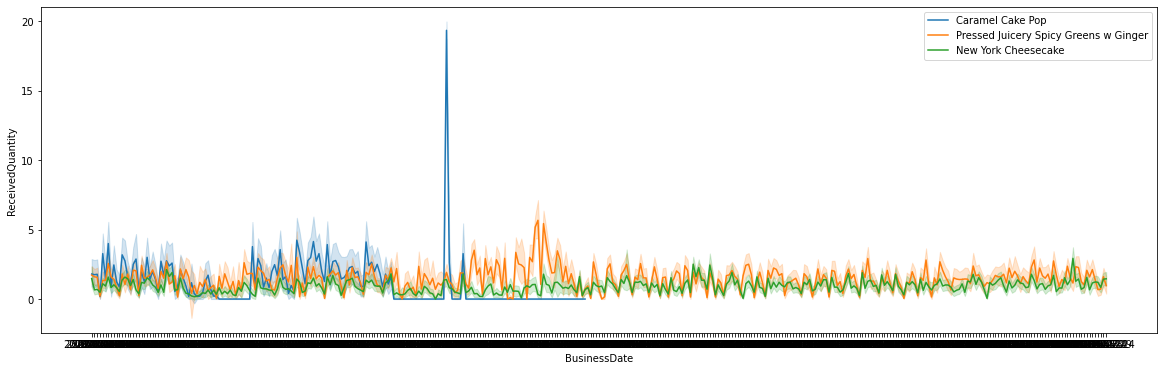

In [ ]:
inventory_graphs(store_18) #for 18 Store
inventory_graphs(store_117) # For 117 Store
inventory_graphs(store_332) # For 332 Store
inventory_graphs(data) #For ALL STORES

## Adding Necessary features to the indiidual stores Dataset

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=dataset['BusinessDate'].min(), end=dataset['BusinessDate'].max())
dataset['BusinessDate'] = pd.to_datetime(dataset['BusinessDate'])
dataset['Holiday'] = dataset['BusinessDate'].isin(holidays)
dataset["IsWeekend"] = dataset['BusinessDate'].dt.dayofweek > 4
dataset['Weekday'] =  dataset['BusinessDate'].dt.day_name()
dataset['BusinessDate'] = dataset['BusinessDate'].astype(str)
dataset[['Year','Month','Date']] = dataset.BusinessDate.str.split("-",expand=True)
dataset['BusinessDate'] = pd.to_datetime(dataset['BusinessDate'])
dataset = dataset.loc[dataset['StoreID'].isin([18,117,332])]
drive_thru = {18:False,117:False,332:True}
dataset['DriveThru'] = dataset['StoreID'].map(drive_thru)
dataset['SellingPrice'] = dataset['SoldQuantity']*3
pasadena_weather = pd.read_excel(path +'/91101.xlsx')
sandeigo_weather = pd.read_excel(path+'/92122.xlsx')
pasadena_weather['BusinessDate'] = pd.to_datetime(pasadena_weather.BusinessDate)
sandeigo_weather['BusinessDate'] = pd.to_datetime(sandeigo_weather.BusinessDate)
d1=pd.merge((dataset[dataset['StoreID']==18]),pasadena_weather, on="BusinessDate", how="left").reset_index(drop=True)
d2=pd.merge((dataset[dataset['StoreID']==117]),pasadena_weather, on="BusinessDate", how="left").reset_index(drop=True)
d3=pd.merge((dataset[dataset['StoreID']==332]),sandeigo_weather, on="BusinessDate", how="left").reset_index(drop=True)
main_data = pd.concat([d1,d2,d3],ignore_index=True)


In [ ]:
main_data

,StoreID,BusinessDate,PLU,Description,ItemType,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,SoldQuantity,...,MissedSales,Holiday,IsWeekend,Weekday,Year,Month,Date,DriveThru,SellingPrice,Temp
0,18,2019-06-29,830620,Honey Raisin Bran Muffin,Core,Food,Bake Case,Muffins & Scones,2.0,1.0,...,2.563950,False,True,Saturday,2019,06,29,False,3.0,70.5
1,18,2019-06-29,6228,Pressed Juicery Spicy Greens w Ginger,Unassigned,Food,Cold Case,Ready to Drink,6.0,0.0,...,0.000000,False,True,Saturday,2019,06,29,False,0.0,70.5
2,18,2019-06-29,12216,Vive Juice Shot,Unassigned,Food,Cold Case,Ready to Drink,0.0,0.0,...,0.000000,False,True,Saturday,2019,06,29,False,0.0,70.5
3,18,2019-06-29,3000277,Mixed Berries & Granola Yogurt Parfait,Unassigned,Food,Cold Case,Ready to Eat,4.0,3.0,...,0.000000,False,True,Saturday,2019,06,29,False,9.0,70.5
4,18,2019-06-29,851004,Jalapeno Cheese Bagel,Core,Food,Bake Case,Bagels,9.0,6.0,...,0.000000,False,True,Saturday,2019,06,29,False,18.0,70.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14490,332,2020-06-29,3000162,Protein Box,Unassigned,Food,Cold Case,Ready to Eat,0.0,3.0,...,2.822207,False,False,Monday,2020,06,29,True,9.0,65.0
14491,332,2020-06-29,3000181,Mixed Fruit Snack Pot,Unassigned,Food,Cold Case,Ready to Eat,0.0,0.0,...,0.000000,False,False,Monday,2020,06,29,True,0.0,65.0
14492,332,2020-06-29,3000211,Muffin - Blueberry Streusel,Core,Food,Bake Case,Muffins & Scones,0.0,15.0,...,0.000000,False,False,Monday,2020,06,29,True,45.0,65.0
14493,332,2020-06-29,3000212,Muffin - Double Chocolate,Core,Food,Bake Case,Muffins & Scones,0.0,2.0,...,0.000000,False,False,Monday,2020,06,29,True,6.0,65.0


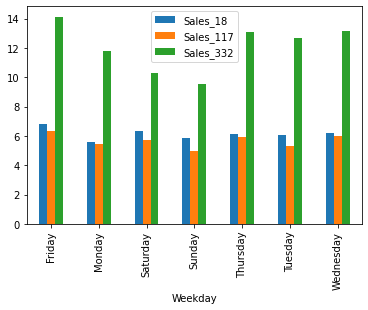

In [ ]:
# Grouping for Graphs
s1 = d1.groupby('Weekday')['SellingPrice'].mean().reset_index()
s2 = d2.groupby('Weekday')['SellingPrice'].mean().reset_index()
s3= d3.groupby('Weekday')['SellingPrice'].mean().reset_index()

sales_impact = pd.merge(s1,s2,on="Weekday", how="left")
sales_impact = pd.merge(sales_impact,s3, on="Weekday", how="left")
cols = ['Weekday','Sales_18','Sales_117','Sales_332']
sales_impact.columns = cols
sales_impact.set_index('Weekday').plot(kind='bar')

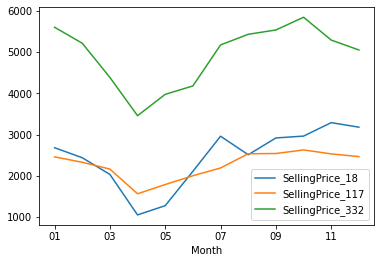

In [ ]:
# Grouping for Graphs
m1 = d1.groupby('Month')['SellingPrice'].sum().reset_index()
m2 = d2.groupby('Month')['SellingPrice'].sum().reset_index()
m3= d3.groupby('Month')['SellingPrice'].sum().reset_index()
month_impact = pd.merge(m1,m2,on="Month", how="left")
month_impact = pd.merge(month_impact,m3, on="Month", how="left")
cols = ['Month','SellingPrice_18','SellingPrice_117','SellingPrice_332']
month_impact.columns = cols
month_impact.set_index('Month').plot(kind='line')

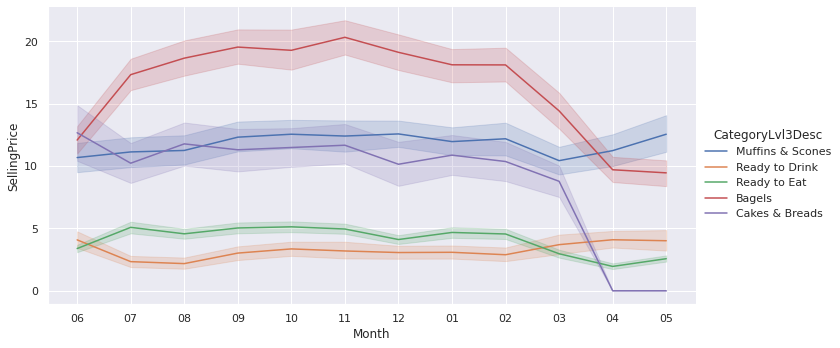

In [ ]:
sns.set(style="darkgrid")
sns.relplot(data=main_data, x="Month", y="SellingPrice", kind="line",height=5, aspect=2,hue='CategoryLvl3Desc')

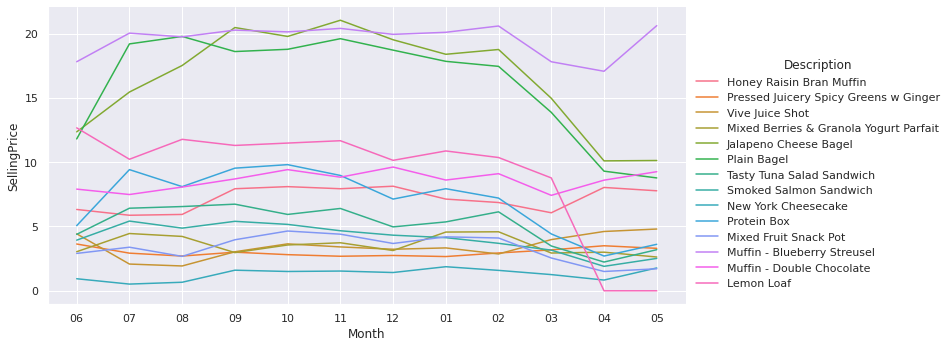

In [ ]:
sns.relplot(data=main_data, x="Month", y="SellingPrice", kind="line",height=5, aspect=2,hue='Description',ci=None)

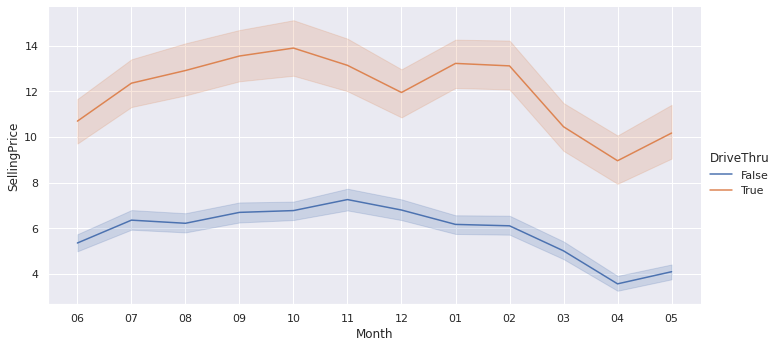

In [ ]:
sns.relplot(data=main_data, x="Month", y="SellingPrice", kind="line",height=5, aspect=2,hue='DriveThru')

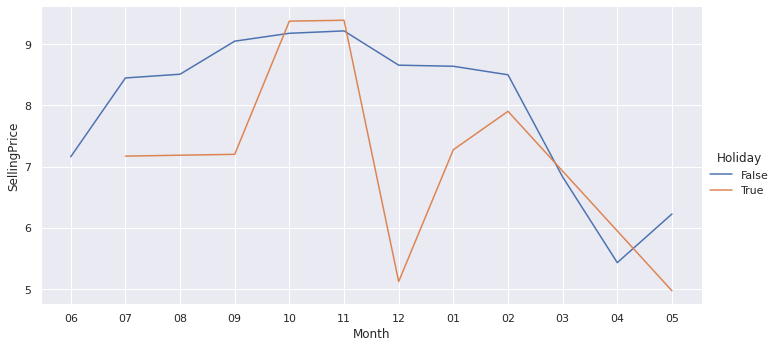

In [ ]:
sns.relplot(data=main_data, x="Month", y="SellingPrice", kind="line",height=5, aspect=2,hue='Holiday',ci=None)

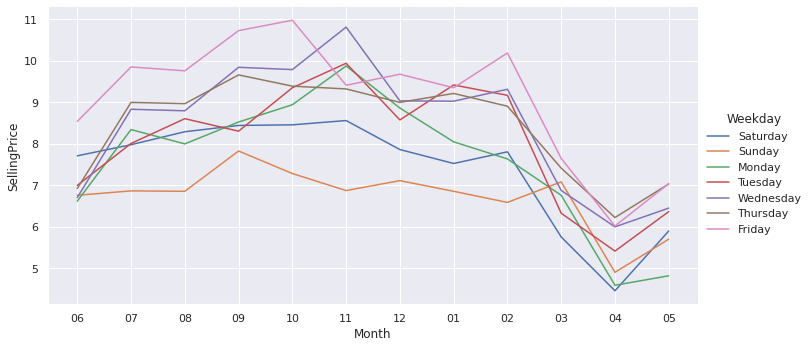

In [ ]:
sns.relplot(data=main_data, x="Month", y="SellingPrice", kind="line",height=5, aspect=2,hue='Weekday',ci=None)

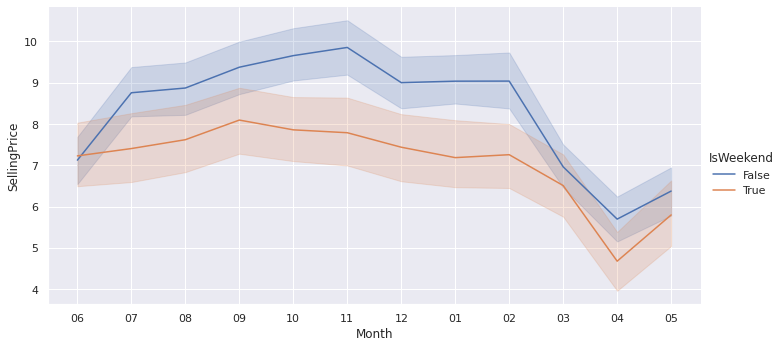

In [ ]:
sns.relplot(data=main_data, x="Month", y="SellingPrice", kind="line",height=5, aspect=2,hue='IsWeekend')

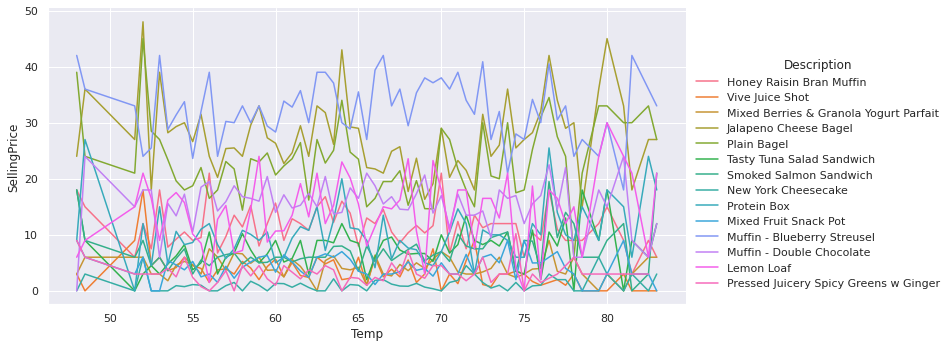

In [ ]:
sns.relplot(data=d3, x="Temp", y="SellingPrice", kind="line",height=5, aspect=2,hue='Description',ci=None)

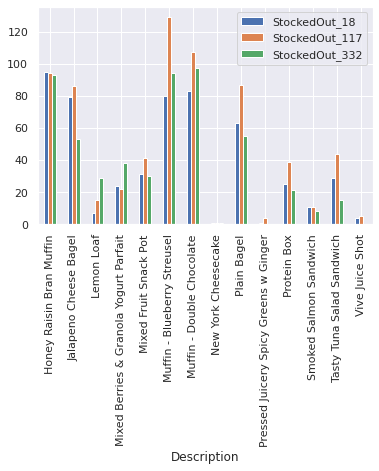

In [ ]:
# Grouping for Graphs
so1 = d1[d1['Year'].astype('int')==2019].groupby('Description')['StockedOut'].sum().reset_index()
so2 = d2[d2['Year'].astype('int')==2019].groupby('Description')['StockedOut'].sum().reset_index()
so3 = d3[d3['Year'].astype('int')==2019].groupby('Description')['StockedOut'].sum().reset_index()
so_impact = pd.merge(so1,so2,on="Description", how="left")
so_impact = pd.merge(so_impact,so3, on="Description", how="left")
cols = ['Description','StockedOut_18','StockedOut_117','StockedOut_332']
so_impact.columns = cols
so_impact.set_index('Description').plot(kind='bar')

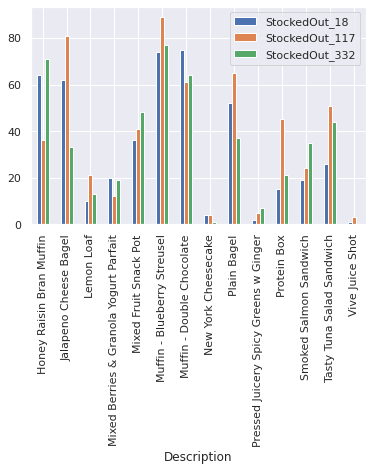

In [ ]:
# Grouping for Graphs
so1_ = d1[d1['Year'].astype('int')==2020].groupby('Description')['StockedOut'].sum().reset_index()
so2_ = d2[d2['Year'].astype('int')==2020].groupby('Description')['StockedOut'].sum().reset_index()
so3_ = d3[d3['Year'].astype('int')==2020].groupby('Description')['StockedOut'].sum().reset_index()
so_impact = pd.merge(so1_,so2_,on="Description", how="left")
so_impact = pd.merge(so_impact,so3_, on="Description", how="left")
cols = ['Description','StockedOut_18','StockedOut_117','StockedOut_332']
so_impact.columns = cols
so_impact.set_index('Description').plot(kind='bar')

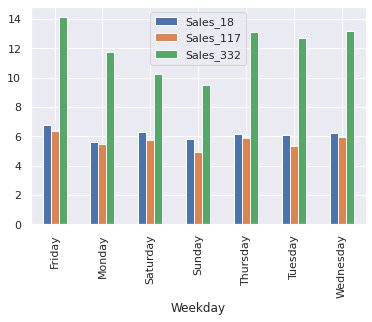

In [ ]:
# Grouping for Graphs
r1 = d1.groupby('Weekday')['SellingPrice'].mean().reset_index()
r2 = d2.groupby('Weekday')['SellingPrice'].mean().reset_index()
r3= d3.groupby('Weekday')['SellingPrice'].mean().reset_index()
sales_impact = pd.merge(s1,s2,on="Weekday", how="left")
sales_impact = pd.merge(sales_impact,s3, on="Weekday", how="left")
cols = ['Weekday','Sales_18','Sales_117','Sales_332']
sales_impact.columns = cols
sales_impact.set_index('Weekday').plot(kind='bar')

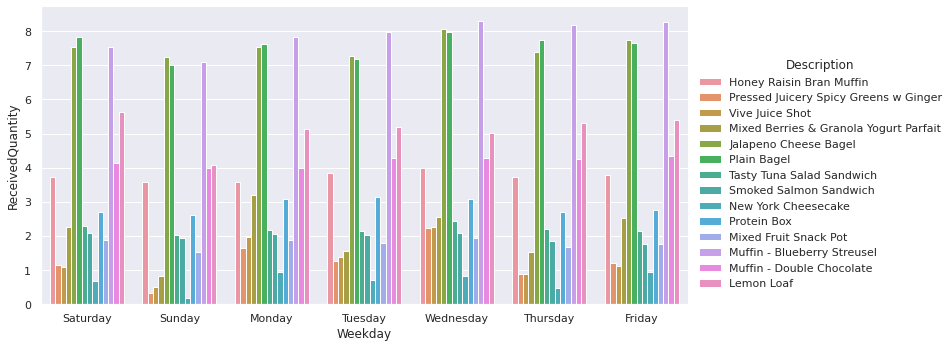

In [ ]:
sns.catplot(data=main_data, x="Weekday", y="ReceivedQuantity", kind="bar",height=5, aspect=2,hue='Description',ci=None)

## Adding features to ALL Stores data for more analysis

In [ ]:
# Few Extra Graphs for All Data
all_data = data.copy()
holidays = cal.holidays(start=all_data['BusinessDate'].min(), end=all_data['BusinessDate'].max())
all_data['BusinessDate'] = pd.to_datetime(all_data['BusinessDate'])
all_data['Holiday'] = all_data['BusinessDate'].isin(holidays)
all_data["IsWeekend"] = all_data['BusinessDate'].dt.dayofweek > 4
all_data['Weekday'] =  all_data['BusinessDate'].dt.day_name()
all_data['BusinessDate'] = all_data['BusinessDate'].astype(str)
all_data[['Year','Month','Date']] = all_data.BusinessDate.str.split("-",expand=True)
all_data['BusinessDate'] = pd.to_datetime(all_data['BusinessDate'])
all_data['SellingPrice'] = all_data['SoldQuantity']*3
temp = {'Month':['01','02','03','04','05','06','07','08','09','10','11','12'],'AverageTemp':[35.55,36.18,46.08,50.88,60.91,69.00,74.62,73.74,68.43,52.05,41.11,36.43]}
avg_temp = pd.DataFrame(temp)
all_data['Month'] = all_data['Month'].astype('str')
all_data = pd.merge(all_data,avg_temp,on='Month',how='left')

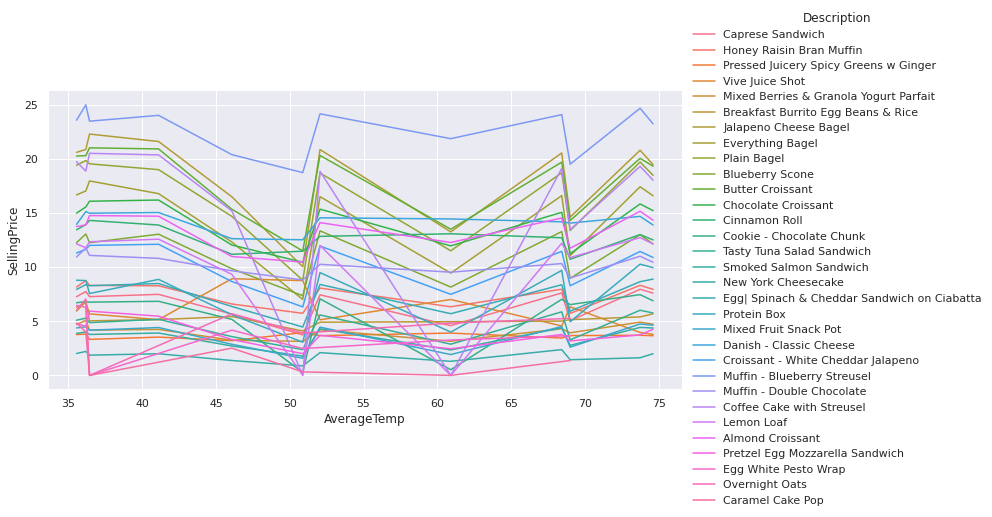

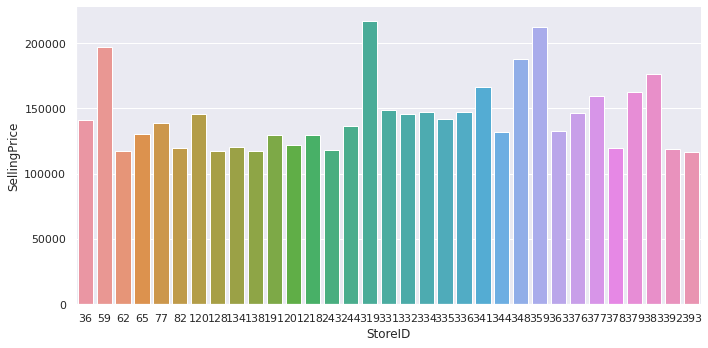

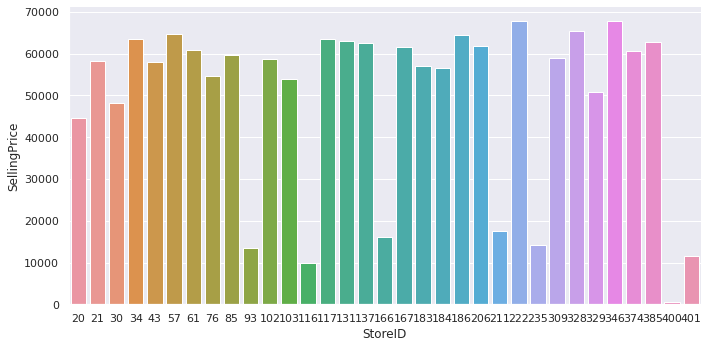

In [ ]:
sns.set(style="darkgrid")
sns.relplot(data=all_data, x="AverageTemp", y="SellingPrice", kind="line",height=5, aspect=2,hue='Description',ci=None)
selling_price_all = all_data.groupby('StoreID')['SellingPrice'].sum().reset_index()
selling_sorted_df_all = selling_price_all.sort_values(by = 'SellingPrice', ascending = False)
sz = selling_sorted_df_all['SellingPrice'].size-1
selling_sorted_df_all['Percentile'] = selling_sorted_df_all['SellingPrice'].rank(method='max').apply(lambda x: 100.0*(x-1)/sz)
top_percentile_all = selling_sorted_df_all[selling_sorted_df_all['Percentile']>75]
bottom_percentile_all = selling_sorted_df_all[selling_sorted_df_all['Percentile']<25]
sns.catplot(data=top_percentile_all, x="StoreID", y="SellingPrice", kind="bar",height=5, aspect=2)
sns.catplot(data=bottom_percentile_all, x="StoreID", y="SellingPrice", kind="bar",height=5, aspect=2)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14495 entries, 39462 to 998047
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   StoreID           14495 non-null  int64         
 1   BusinessDate      14495 non-null  datetime64[ns]
 2   PLU               14495 non-null  int64         
 3   Description       14495 non-null  object        
 4   ItemType          14495 non-null  object        
 5   CategoryLvl1Desc  14495 non-null  object        
 6   CategoryLvl2Desc  14495 non-null  object        
 7   CategoryLvl3Desc  14495 non-null  object        
 8   ReceivedQuantity  14495 non-null  float64       
 9   SoldQuantity      14495 non-null  float64       
 10  EndQuantity       14495 non-null  float64       
 11  LatestOrder       14495 non-null  int64         
 12  StockedOut        14495 non-null  int64         
 13  GroupID           14495 non-null  float64       
 14  MissedSales      

## Section 2

GAN code is here. But we haven't used anywhere in the code as it was not necessary

In [ ]:
#Generate GANs
# from ctgan import CTGANSynthesizer
# discrete_columns = ['BusinessDate','Description','ItemType','CategoryLvl1Desc','CategoryLvl2Desc','CategoryLvl3Desc','Holiday','IsWeekend','Weekday']
# ctgan = CTGANSynthesizer(epochs=10)
# ctgan.fit(dataset, discrete_columns)
# #generate synthetic data, 1000 rows of data
# samples = ctgan.sample(1000)

In [ ]:
# CHange all values to numericals
individual_stores_data = main_data.copy()
main_data = main_data.drop(['CategoryLvl1Desc','Description'],axis=1)
bool_list = ['Holiday','IsWeekend','DriveThru']
week_list = ['Weekday']
item_type = ['ItemType']
case_type= ['CategoryLvl2Desc']
categ_list = ['CategoryLvl3Desc']
def binary_map(x):
    return x.map({True: 1, False: 0})
def categ_map(q):
    return q.map({'Muffins & Scones':0,'Ready to Drink':1,'Ready to Eat':2,'Bagels':3,'Cakes & Breads':4})
def case_type_map(p):
    return p.map({'Bake Case': 1, 'Cold Case': 0})
def item_type_map(y):
    return y.map({'Core': 1, 'Unassigned': 0})
def weekday(z):
    return z.map({'Sunday':0, 'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6})
main_data[bool_list] = main_data[bool_list].apply(binary_map)
main_data[week_list] = main_data[week_list].apply(weekday)
main_data[item_type] = main_data[item_type].apply(item_type_map)
main_data[case_type] = main_data[case_type].apply(case_type_map)
main_data[categ_list] = main_data[categ_list].apply(categ_map)

## Correlation Matrix

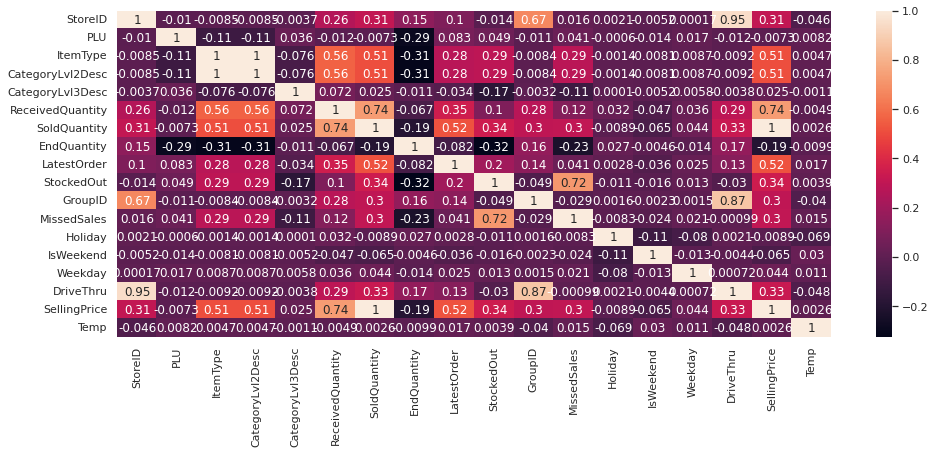

In [ ]:
corr = main_data.corr()
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(corr,annot=True)
plt.show()

## Selecting Best Suitable columns based on correlation heatmap

In [ ]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.3:
            if columns[j]:
                columns[j] = False
selected_columns = corr.columns[columns]

In [ ]:
ex = pd.Index(['ReceivedQuantity','SoldQuantity'])
selected_columns = selected_columns.append(ex)
selected_data = main_data[selected_columns]

In [ ]:
selected_data


,StoreID,PLU,ItemType,CategoryLvl3Desc,EndQuantity,Holiday,IsWeekend,Weekday,Temp,ReceivedQuantity,SoldQuantity
0,18,830620,1,0,0.0,0,1,6,70.5,2.0,1.0
1,18,6228,0,1,8.0,0,1,6,70.5,6.0,0.0
2,18,12216,0,1,3.0,0,1,6,70.5,0.0,0.0
3,18,3000277,0,2,4.0,0,1,6,70.5,4.0,3.0
4,18,851004,1,3,0.0,0,1,6,70.5,9.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
14490,332,3000162,0,2,0.0,0,0,1,65.0,0.0,3.0
14491,332,3000181,0,2,0.0,0,0,1,65.0,0.0,0.0
14492,332,3000211,1,0,5.0,0,0,1,65.0,0.0,15.0
14493,332,3000212,1,0,1.0,0,0,1,65.0,0.0,2.0


## Linear Regression

In [ ]:
def linear_regression(df):
  #Splitting test and train data
  np.random.seed(0)
  df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)
  # Scaling the Train data
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  num_vars = ['StoreID', 'PLU', 'ItemType', 'CategoryLvl3Desc', 'EndQuantity','Holiday', 'IsWeekend', 'Weekday', 'Temp', 'ReceivedQuantity','SoldQuantity']
  df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

  # Dividing the training data set into X and Y
  y_train = df_train.pop('SoldQuantity')
  X_train = df_train

  # Model Building on train data
  import statsmodels.api as sm
  X_train_lm = sm.add_constant(X_train)
  lr_1 = sm.OLS(y_train.astype(float), X_train_lm.astype(float)).fit()
  print(lr_1.summary())

  # Scaling Testing data
  df_test[num_vars] = scaler.transform(df_test[num_vars])
  # Diving Test data in X and Y
  y_test = df_test.pop('SoldQuantity')
  X_test = df_test

  # Adding constant variable to test dataframe
  X_test_m1 = sm.add_constant(X_test)
  # Predicting on test data using the model build above
  y_pred_m1 = lr_1.predict(X_test_m1)

In [ ]:
linear_regression(selected_data)

                            OLS Regression Results                            
Dep. Variable:           SoldQuantity   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     1771.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        08:06:30   Log-Likelihood:                 12206.
No. Observations:               11596   AIC:                        -2.439e+04
Df Residuals:                   11585   BIC:                        -2.431e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0891      0.005  

### Remaining Ensemble Models

In [ ]:
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
             'max_depth':[2,5,10,15,20,25]
         }
    },
        'gbm_regression' : {
        'model': GradientBoostingRegressor(),
        'params' : {
            'learning_rate': [0.2],
            'n_estimators': [100],
             'max_depth' : [5]
         }
    },
        'lgb' : {
        'model': LGBMRegressor(),
        'params' : {
            'learning_rate':[0.01],
            'n_estimators':[1440],
             'max_depth' : [12]
         }
     },
        'XGB_regression' : {
        'model': XGBRegressor(),
        'params' : {
            'learning_rate': [0.1],
            'n_estimators': [1500],
             'max_depth' : [2]
         }
    },
        'XGBRF_regression' : {
        'model': XGBRFRegressor(),
        'params' : {
            'learning_rate':[0.5],
            'n_estimators':[10,50,100,500,1000,1500],
            'max_depth' : [1,2,5,7,10]
         }
    }
}

In [ ]:
df_input_ = selected_data[['SoldQuantity','ReceivedQuantity','EndQuantity','Temp','Holiday','Weekday']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input_)
features = data_scaled
target = features[:,0]
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.20,random_state=123,shuffle=False)

In [ ]:
scores = []
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'],mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_temp = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_temp

[08:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,model,best_score,best_params
0,random_forest,0.999759,{'max_depth': 10}
1,gbm_regression,0.999705,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."
2,lgb,0.993620,"{'learning_rate': 0.01, 'max_depth': 12, 'n_es..."
3,XGB_regression,0.999704,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
4,XGBRF_regression,-3.745565,"{'learning_rate': 0.5, 'max_depth': 10, 'n_est..."


Thought of improving model. so checking best features

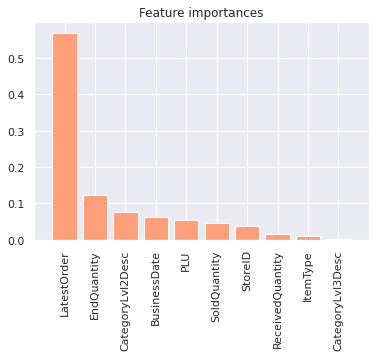

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_imp = selected_data.copy()
y = model_imp.pop('SoldQuantity')
X = model_imp
X = X.fillna(X.mean())
y = y.fillna(y.mean())
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators = 100, random_state=42)
rf.fit(x_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],color="lightsalmon", align="center")
plt.xticks(range(x_train.shape[1]), main_data.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

## LSTM

In [ ]:
# LSTM
columns_list = ['SoldQuantity','PLU','CategoryLvl3Desc','ReceivedQuantity','EndQuantity','Holiday','IsWeekend', 'Weekday', 'Temp']
lstm_data = selected_data[columns_list]

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(lstm_data)
features = data_scaled
target = features[:,0]
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.20,random_state=123,shuffle=False)
win_length = 30
batch_size = 100
num_features=9
train_generator = TimeseriesGenerator(x_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           70656     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit_generator(train_generator, epochs=10,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])

Epoch 1/10
116/116 [==============================] - 37s 264ms/step - loss: 0.0132 - mean_absolute_error: 0.0859 - val_loss: 0.0300 - val_mean_absolute_error: 0.1425
Epoch 2/10
116/116 [==============================] - 31s 267ms/step - loss: 0.0133 - mean_absolute_error: 0.0856 - val_loss: 0.0291 - val_mean_absolute_error: 0.1381
Epoch 3/10
116/116 [==============================] - 29s 249ms/step - loss: 0.0134 - mean_absolute_error: 0.0861 - val_loss: 0.0299 - val_mean_absolute_error: 0.1439
Epoch 4/10
116/116 [==============================] - 30s 260ms/step - loss: 0.0136 - mean_absolute_error: 0.0865 - val_loss: 0.0304 - val_mean_absolute_error: 0.1461


In [ ]:
model.evaluate_generator(test_generator, verbose=0) 

[0.03037007711827755, 0.14605234563350677]

In [ ]:
predictions=model.predict_generator(test_generator)
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)
rev_trans=scaler.inverse_transform(df_pred)
lstm_final=lstm_data[predictions.shape[0]*-1:]
lstm_final['Sold_Pred']=rev_trans[:,0]

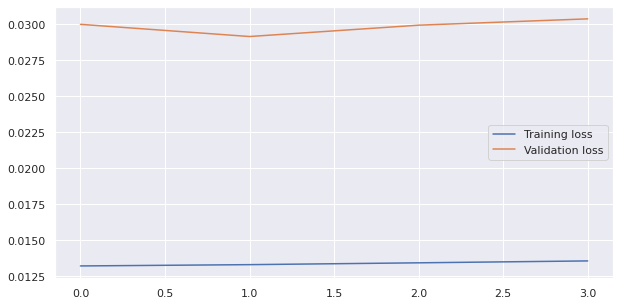

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

## **Section 3**

## Initiative 1

In [ ]:
main_data_modified = main_data[main_data['StoreID']==18]
main_data_modified = main_data_modified[main_data_modified['PLU']==3000277]

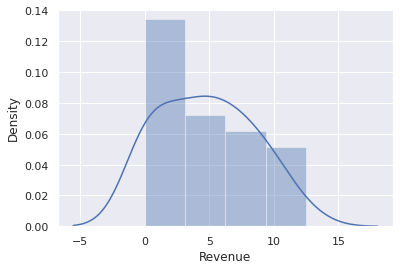

In [ ]:
columns_list = ['BusinessDate','SoldQuantity','ReceivedQuantity','EndQuantity','Holiday','IsWeekend', 'Weekday', 'Year' ,'Month','Date','Temp']
modified_data = main_data_modified[columns_list]
modified_data = modified_data[modified_data['Month'].astype('str') == '07']
df_input = modified_data
df_input['Revenue'] = df_input['SoldQuantity'] * 2.5
import seaborn as sns
sns.distplot(df_input["Revenue"])
df_input["count"] = 1
def bins(x):
    for bar in range(0,10,1):
        if x <= bar:
            return bar
df_input["Rev_dist"] = df_input["Revenue"].apply(lambda x: bins(x))
pivot_table = pd.pivot_table(df_input, index = ["Rev_dist"], values = ["count"], aggfunc = np.sum)
# import model from SKLearn
from sklearn.cluster import KMeans
# K -clusters is equal to 3 because things will be sorted into A, B, and C
kmeans = KMeans(n_clusters=3)
kmeans.fit(pivot_table)
pivot_table["category"] = kmeans.labels_
ABC_dict = {0: "A",1: "C",2: "B"}
pivot_table["ABC"] = pivot_table["category"].apply(lambda x: ABC_dict[x])
df_input = pd.merge(df_input, pivot_table, on = "Rev_dist", how ="left")

In [ ]:
def calculate_mean(date,week,main_data):
    date = date.strftime('%Y-%m-%d')
    main_data_ = main_data[main_data['Weekday']==week]
    main_data_['BusinessDate'] = main_data_['BusinessDate'].dt.strftime('%Y-%m-%d')
    sub_df = main_data_[((main_data_['BusinessDate']<date))]
    a_df = sub_df[-4:]
    a = a_df['SoldQuantity'].mean()
    return a

In [ ]:
df_ = df_input.copy()
df_input['prev_mean'] = df_input.apply(lambda x: calculate_mean(x['BusinessDate'],x['Weekday'],df_),axis=1)
df_input.loc[:,'prev_mean'] = df_input.prev_mean.shift(-2)
df_input.dropna()
df_input.loc[:,'adjusted_eq'] = df_input.EndQuantity.shift(-1)
Received_quantity_avg = df_input['ReceivedQuantity'].mean()
Received_quantity_avg = math.ceil(Received_quantity_avg*0.3)
df_input['New_RecievedQuantity'] = df_input['ReceivedQuantity']+df_input['adjusted_eq']+Received_quantity_avg
df_input = df_input.drop(['prev_mean'],axis=1)
df_input = df_input.dropna()
lstm_df = df_input.copy()
lstm_df = lstm_df.drop(['BusinessDate','ABC'],axis=1)


In [ ]:
choose = 1

## LSTM for Initiative

In [ ]:
if choose==0:
    lstm_df = lstm_df[['SoldQuantity','ReceivedQuantity']]
else:
    lstm_df = lstm_df[['SoldQuantity','New_RecievedQuantity']]


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(lstm_df)
features = data_scaled
target = features[:,0]
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.20,random_state=123,shuffle=False)
win_length = 3
batch_size = 1
num_features=2
train_generator = TimeseriesGenerator(x_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(1))
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit_generator(train_generator, epochs=10,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])
predictions=model.predict_generator(test_generator)
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)
rev_trans=scaler.inverse_transform(df_pred)
df_final_lstm=lstm_df[predictions.shape[0]*-1:]
df_final_lstm['Sold_Pred']=rev_trans[:,0]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 128)            67072     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 3, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 128)            131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3, 128)            0         
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

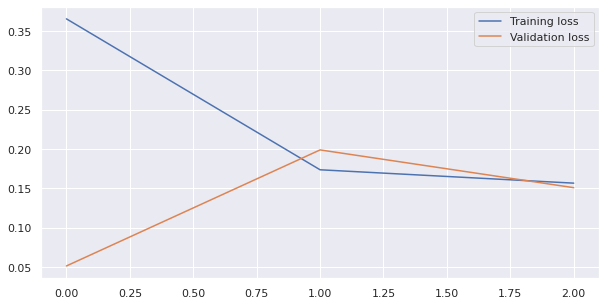

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()